# Battery life cycle prediction - data exploration

We reproduce the findings reported in the original paper in this section. We use an ElasticNet model as well as Linear and Logistic Regression models. The paper implemented three models: "Variance Model", "Discharge Model" and "Full Model". The modelling approach was to feature engineer features that are linearly correlated to the response. This allows for the use of linear models e.g. Linear and Logistic regression.

Our approach is to recreate and test the original linear models, and then to use Deep Learning techniques to derive the features automatically as an additional step and to compare results.
We however start by loading and exploring the data.

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import src.features.rebuilding_features as rf
from os.path import join
import src.models.data_pipeline as dp

import tensorflow as tf
import pandas as pd
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

DATA_DIR = join("../../data/external")


In [6]:
print (physical_devices)

[]


## Data Loading

We load the data used by the original paper. To ease analysis due to data size we start by loading one batch only. The original paper used 3 batches (batch1-3.pkl), one for training, one for testing and another for further testing. We start by analysing the training dataset.

The data associated with each battery (cell) can be grouped into one of three categories: descriptors, summary, and cycle.

* Descriptors for each battery include charging policy, cycle life, barcode and channel. Note that barcode and channel are currently not available in the pkl files).
* Summary data include information on a per-cycle basis, including cycle number, discharge capacity, charge capacity, internal resistance, maximum temperature, average temperature, minimum temperature, and chargetime.
* Cycle data include information within a cycle, including time, charge capacity, current, voltage, temperature, discharge capacity. We also include derived vectors of discharge dQ/dV, linearly interpolated discharge capacity (i.e. Qdlin) and linearly interpolated temperature (i.e. Tdlin).

In [7]:
path1 = Path("../../data/external/batch1.pkl")
batch1 = pickle.load(open(path1, 'rb'))

In [8]:
batch1.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])

In [9]:
#batch1['b1c0']
dp.print_dict_keys(batch1, max_depth=1)

[b1c0]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c1]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c2]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c3]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c4]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c5]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c6]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c7]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c8]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c9]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c10]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c11]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c12]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c13]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c14]
  [cycle_life]
  [charge_policy]
  [summary]
  [cycles]
[b1c15]
  [cycle_life]
  [charge_policy]
  [summar

## Exploratory Analysis
We start by considering the response variable i.e. cycle life of each battery.

In [10]:
cycle_life_list = []
for battery in batch1:
    cycle_life_list.append(batch1[battery]["cycle_life"][0][0])

In [11]:
df_response = pd.DataFrame(cycle_life_list, columns =['Life Cycle'])

In [12]:
#plt.hist(cycle_life_list)  # density=False would make counts
#plt.ylabel('Count')
#plt.xlabel('Life Cycle');

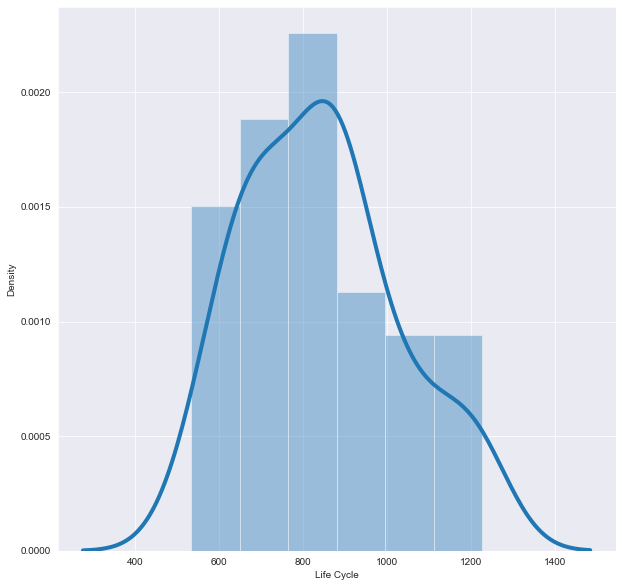

In [13]:
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))

fig = sns.distplot(cycle_life_list, label="Probability Density", norm_hist=True, kde_kws={"lw":4}, ax=axes)
#fig = sns.distplot(cycle_life_list, label="Probability Density", norm_hist=True, ax=axes)
_ = fig.xaxis.set_label_text("Life Cycle")

In [14]:
df_response.describe()

,Life Cycle
count,46.000000
mean,844.717391
std,184.629198
min,534.000000
25%,703.250000
50%,858.500000
75%,914.250000
max,1227.000000


In [15]:
batch1['b1c0']['summary']

{'IR': array([0.        , 0.01674235, 0.01672431, ..., 0.01708527, 0.01707222,
        0.0170891 ]),
 'QC': array([0.       , 1.0710422, 1.0716741, ..., 1.0263145, 1.0266199,
        1.0260537]),
 'QD': array([0.       , 1.0706892, 1.0719005, ..., 1.0264986, 1.0266768,
        1.0262098]),
 'Tavg': array([ 0.        , 31.87501078, 31.93149033, ..., 32.29614847,
        32.20877834, 32.20080358]),
 'Tmin': array([ 0.      , 29.56613 , 29.604385, ..., 29.727167, 29.654888,
        29.681129]),
 'Tmax': array([ 0.      , 35.652016, 35.692978, ..., 36.750278, 36.758877,
        36.561554]),
 'chargetime': array([ 0.        , 13.34125   , 13.42577667, ..., 13.42549833,
        13.34097167, 13.42571167]),
 'cycle': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.187e+03, 1.188e+03,
        1.189e+03])}

In [16]:
batch1['b1c0']['cycle_life'][0][0]

1190.0

We now consider discharge capacity as a function of cycle number for each battery cell tested. This graph is created from the data summarised at a cycle level.

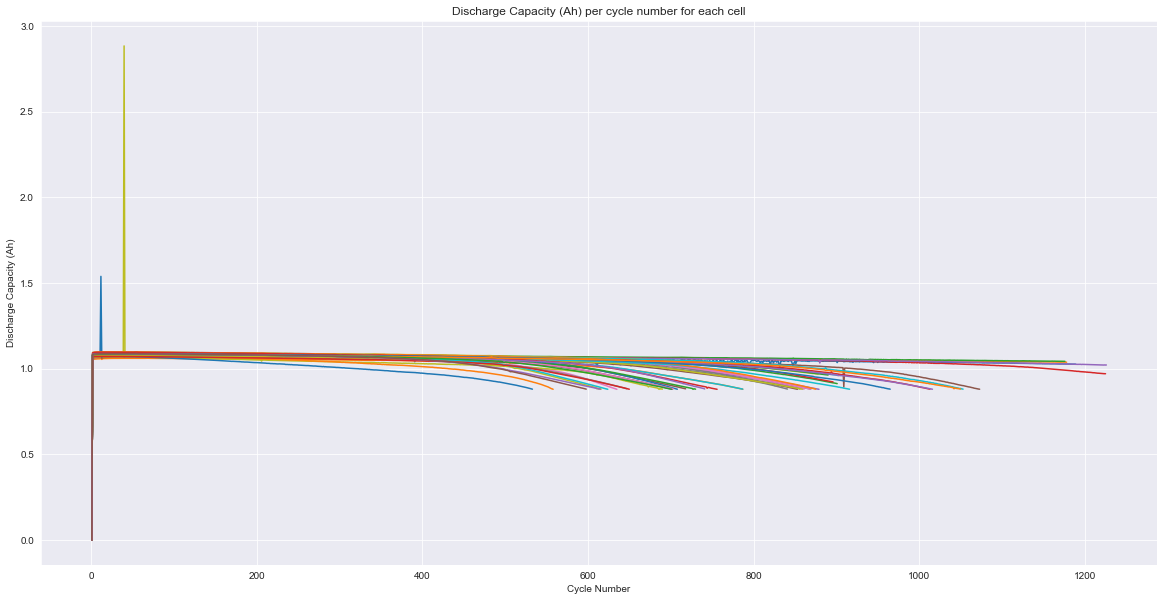

In [17]:
plt.figure(figsize=(20,10))
for i in batch1.keys():
    plt.plot(batch1[i]['summary']['cycle'], batch1[i]['summary']['QD'])
_ = plt.title('Discharge Capacity (Ah) per cycle number for each cell')
_ = plt.xlabel('Cycle Number')
_ = plt.ylabel('Discharge Capacity (Ah)')


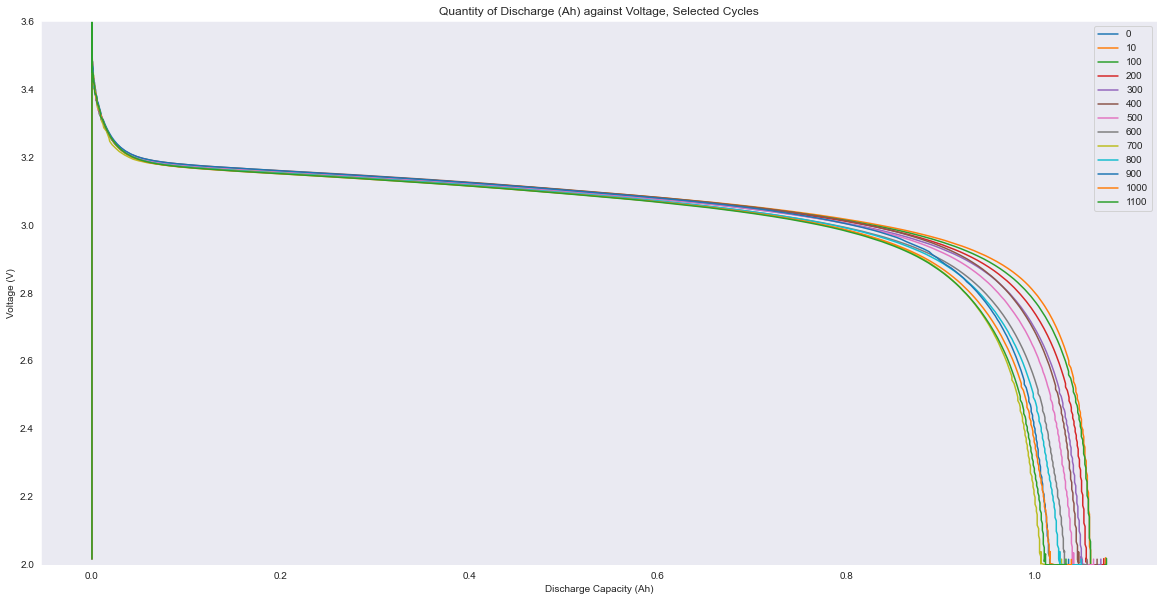

In [18]:
plt.figure(figsize=(20,10))
for i, cycle in batch1["b1c0"]["cycles"].items():
    if (int(i)==10) | (int(i) % 100 == 0):
        plt.plot(cycle["Qd"], cycle["V"], label=i)
plt.title('Quantity of Discharge (Ah) against Voltage, Selected Cycles')
_ = plt.ylabel('Voltage (V)')
_ = plt.xlabel('Discharge Capacity (Ah)')
plt.ylim(2,3.6)
plt.grid()
plt.legend()
plt.show()

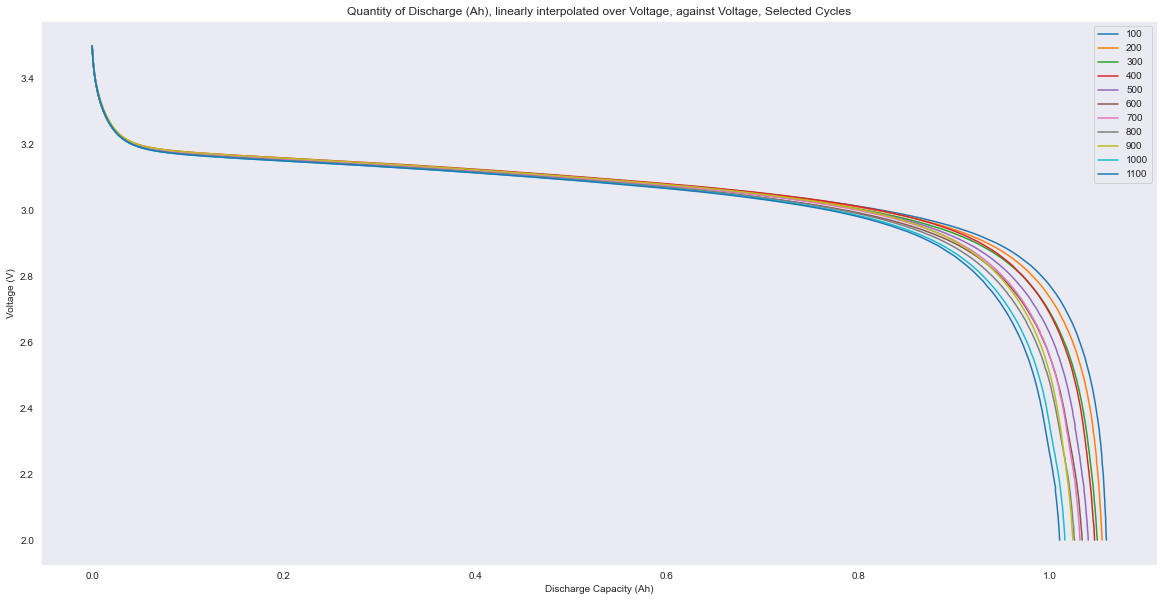

In [19]:
plt.figure(figsize=(20,10))
v_space = np.linspace(3.5, 2.0, 1000)
for i, cycle in batch1["b1c0"]["cycles"].items():
    if (int(i)>0) & (int(i) % 100 == 0):
        plt.plot(cycle["Qdlin"], v_space, label = i)
plt.title('Quantity of Discharge (Ah), linearly interpolated over Voltage, against Voltage, Selected Cycles')
_ = plt.ylabel('Voltage (V)')
_ = plt.xlabel('Discharge Capacity (Ah)')
plt.grid()
plt.legend()
plt.show()

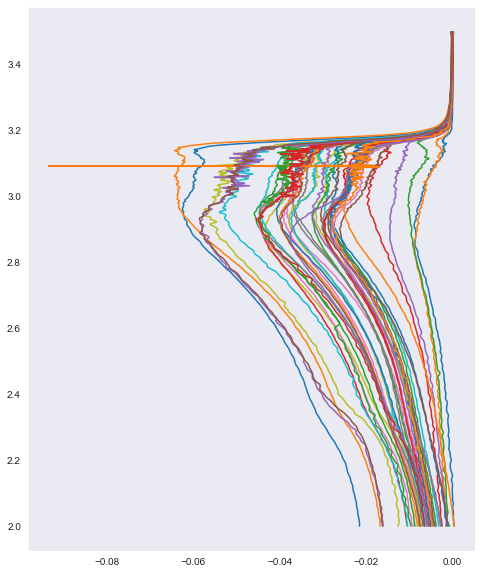

In [20]:
v_space = np.linspace(3.5,2,1000)   # does this make sense?
plt.figure(figsize=(8,10))
for cell in batch1.values():
    c10 = cell['cycles']['10']
    c100 = cell['cycles']['100']
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    plt.plot(dQ_100_10, v_space)
plt.grid()
plt.show()

## Preprocessing and feature selection

We load features we have engineered according to the original paper from file. We used the code from the original paper to perform the feature engineering as a pre-processing step.
The "src/features/rebuilding_features.py" script can be used for generating this dataset from the original data.

In [21]:
all_batches_dict = rf.load_batches_to_dict()
features_df = rf.build_feature_df(all_batches_dict)

save_csv_path = join(DATA_DIR, "rebuild_features.csv")
features_df.to_csv(save_csv_path, index=False)
print("Saved features to ", save_csv_path)

Loading batch1 ...
Loading batch2 ...
Loading batch3 ...
Done loading batches
Start building features ...
Done building features
Saved features to  ../../data/external\rebuild_features.csv
